In [1]:
import pandas as pd
import numpy as np
import pickle

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
# from tensorflow import keras
import keras
from keras import layers
import os
import random
from sklearn.model_selection import train_test_split

In [3]:
print(keras.__version__)

3.5.0


In [4]:
df=pd.read_pickle("dataframe_keywords.pkl")

In [5]:
df.head(2)

,Date_logged,movie_id,Name,Year,overview,genres,keywords,actors,director,average_rating,vote_count,popularity,rating_given
0,2021-10-02,278,The Shawshank Redemption,1994,Imprisoned in the 1940s for the double murder ...,"Drama, Crime","prison, friendship, police brutality, corrupti...","Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Frank Darabont,8.706,26839,150.307,5.0
1,2021-10-02,489,Good Will Hunting,1997,When professors discover that an aimless janit...,Drama,"boston, massachusetts, professor, baseball, ma...","Matt Damon, Robin Williams, Ben Affleck, Stell...",Gus Van Sant,8.158,12188,72.632,5.0


In [6]:
df=df[["movie_id","Name","keywords","rating_given"]]

In [7]:
df.head(2)

,movie_id,Name,keywords,rating_given
0,278,The Shawshank Redemption,"prison, friendship, police brutality, corrupti...",5.0
1,489,Good Will Hunting,"boston, massachusetts, professor, baseball, ma...",5.0


In [8]:
# Convert keywords from a string to a list (if they are stored as comma-separated strings)
df['keywords'] = df['keywords'].apply(lambda x: x.split(', '))

In [9]:
from sklearn.preprocessing import LabelEncoder

# Flatten the list of all keywords across the dataset
all_keywords = [keyword for keywords_list in df['keywords'] for keyword in keywords_list]

# Create a LabelEncoder and fit it on the unique keywords
le = LabelEncoder()
le.fit(all_keywords)

# Now encode each keyword list into integer IDs
df['keywords_encoded'] = df['keywords'].apply(lambda keywords: le.transform(keywords))

In [10]:
df.head()

,movie_id,Name,keywords,rating_given,keywords_encoded
0,278,The Shawshank Redemption,"[prison, friendship, police brutality, corrupt...",5.0,"[1330, 715, 1297, 403, 172, 840, 1331, 475, 13..."
1,489,Good Will Hunting,"[boston, massachusetts, professor, baseball, m...",5.0,"[236, 1057, 1340, 165, 1066, 739, 796, 1023, 7..."
2,284053,Thor: Ragnarok,"[superhero, based on comic, sequel, alien plan...",4.0,"[1662, 167, 1508, 58, 662, 1196, 40, 549, 1050..."
3,299534,Avengers: Endgame,"[superhero, time travel, space travel, time ma...",4.0,"[1662, 1748, 1599, 1745, 167, 1508, 55, 1663, ..."
4,155,The Dark Knight,"[joker, sadism, chaos, secret identity, crime ...",5.0,"[932, 1447, 317, 1490, 428, 1662, 96, 1463, 16..."


In [11]:
from keras_preprocessing.sequence import pad_sequences

# Define the maximum number of keywords (you can choose a limit)
MAX_KEYWORDS = 20

# Pad the sequences (post-padding will add zeros after shorter sequences)
X_keywords_padded = pad_sequences(df['keywords_encoded'], maxlen=MAX_KEYWORDS, padding='post')


In [12]:
df.head()

,movie_id,Name,keywords,rating_given,keywords_encoded
0,278,The Shawshank Redemption,"[prison, friendship, police brutality, corrupt...",5.0,"[1330, 715, 1297, 403, 172, 840, 1331, 475, 13..."
1,489,Good Will Hunting,"[boston, massachusetts, professor, baseball, m...",5.0,"[236, 1057, 1340, 165, 1066, 739, 796, 1023, 7..."
2,284053,Thor: Ragnarok,"[superhero, based on comic, sequel, alien plan...",4.0,"[1662, 167, 1508, 58, 662, 1196, 40, 549, 1050..."
3,299534,Avengers: Endgame,"[superhero, time travel, space travel, time ma...",4.0,"[1662, 1748, 1599, 1745, 167, 1508, 55, 1663, ..."
4,155,The Dark Knight,"[joker, sadism, chaos, secret identity, crime ...",5.0,"[932, 1447, 317, 1490, 428, 1662, 96, 1463, 16..."


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212 entries, 0 to 211
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   movie_id          212 non-null    int64  
 1   Name              212 non-null    object 
 2   keywords          212 non-null    object 
 3   rating_given      212 non-null    float64
 4   keywords_encoded  212 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 9.9+ KB


In [14]:
# Convert movie_id and target (rating_given) to numpy arrays
X_movie_id = np.array(df['movie_id'], dtype=np.int32)
y_rating = np.array(df['rating_given'], dtype=np.float32)

In [16]:
from keras import layers, models
# from layers import Flatten, Embedding, Input, Concatenate, Dense
# Define hyperparameters
max_movie_id = df['movie_id'].max()  # Find the maximum movie ID

hidden_units = (32, 16)  # You can adjust these based on your needs
movie_embedding_size = 8  # Size of the movie embedding vector
keyword_embedding_size = 16  # Size of the keyword embedding vector
n_keywords = 1932  # Number of unique keywords (based on your dataset)
# Inputs
movie_id_input = layers.Input(shape=(1,), name='movie_id')
keywords_input = layers.Input(shape=(20,), name='keywords_input')  # 20 is the max length of the padded keyword sequences

# Embedding layers
movie_embedded = layers.Embedding(input_dim=max_movie_id + 1,
                                  output_dim=movie_embedding_size, 
                                  input_length=1, 
                                  name='movie_embedding')(movie_id_input)
# Embedding layers
movie_embedding = layers.Flatten()(movie_embedded)  # Shape: (None, 8)

# Embedding for keywords (unique keyword count is 1932)
keywords_embedded = layers.Embedding(input_dim=1932, 
                                     output_dim=keyword_embedding_size, 
                                     input_length=None, 
                                     name='keyword_embedding')(keywords_input)
keywords_embedding = layers.Flatten()(keywords_embedded)  # Shape: (None, 20*16)

# Concatenate
concatenated = layers.Concatenate()([movie_embedding, keywords_embedding])  # Shape: (None, 8 + 320)

# Add Dense layers (MLP) for prediction
out = layers.Dense(32, activation='relu')(concatenated)
out = layers.Dense(1, activation='linear')(out)

# Add hidden layers
for n_hidden in hidden_units:
    out = layers.Dense(n_hidden, activation='relu')(out)

# Output layer: predicted rating
out = layers.Dense(1, activation='linear', name='prediction')(out)

In [17]:
# Define the model
model = models.Model(inputs=[movie_id_input, keywords_input], outputs=out)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Check the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ movie_id            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keywords_input      │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_embedding     │ (None, 1, 8)      │  9,381,408 │ movie_id[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keyword_embedding   │ (None, 20, 16)    │     30,912 │ keywords_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 8)         │          0 │ movie_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 320)       │          0 │ keyword_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 328)       │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │     10,528 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         33 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │         64 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 16)        │        528 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prediction (Dense)  │ (None, 1)         │         17 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,423,490 (35.95 MB)

 Trainable params: 9,423,490 (35.95 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Step 3: Split the dataset into training and validation sets
from sklearn.model_selection import train_test_split

# Assuming df contains the entire dataset (movies and ratings)
df_train, df_val = train_test_split(df, test_size=0.1, random_state=42)  # 90% train, 10% validation

# Prepare validation data (use the same padding and conversion as for the training set)
X_val_keywords_padded = pad_sequences(df_val['keywords_encoded'], maxlen=MAX_KEYWORDS, padding='post', truncating='post')
X_val_movie_id = np.array(df_val['movie_id'], dtype=np.int32)
y_val_rating = np.array(df_val['rating_given'], dtype=np.float32)


In [19]:
# Step 4: Train the model
history = model.fit(
    [X_movie_id, X_keywords_padded],  # Training inputs: movie_id and padded keywords
    y_rating,                         # Target: rating_given
    batch_size=10,                    # Batch size (small dataset, so small batch size)
    epochs=20,                        # Number of epochs
    verbose=1,                        # Show training progress
    validation_data=([X_val_movie_id, X_val_keywords_padded], y_val_rating)  # Validation data
)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - loss: 13.6854 - mean_absolute_error: 3.6370 - val_loss: 11.3853 - val_mean_absolute_error: 3.2968
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - loss: 10.3730 - mean_absolute_error: 3.1173 - val_loss: 4.8395 - val_mean_absolute_error: 1.8648
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - loss: 4.4656 - mean_absolute_error: 1.8056 - val_loss: 2.8336 - val_mean_absolute_error: 1.3596
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - loss: 2.1930 - mean_absolute_error: 1.2221 - val_loss: 1.3735 - val_mean_absolute_error: 0.9275
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - loss: 0.5895 - mean_absolute_error: 0.6180 - val_loss: 0.6625 - val_mean_absolute_error: 0.5875
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - loss: 0.2469 - mean_absolute_error: 0.3881 - val_loss: 0.5304 - val_mean_absolute_error: 0.4672
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - loss: 0.0965 - mean_absolute_error: 0.2298 

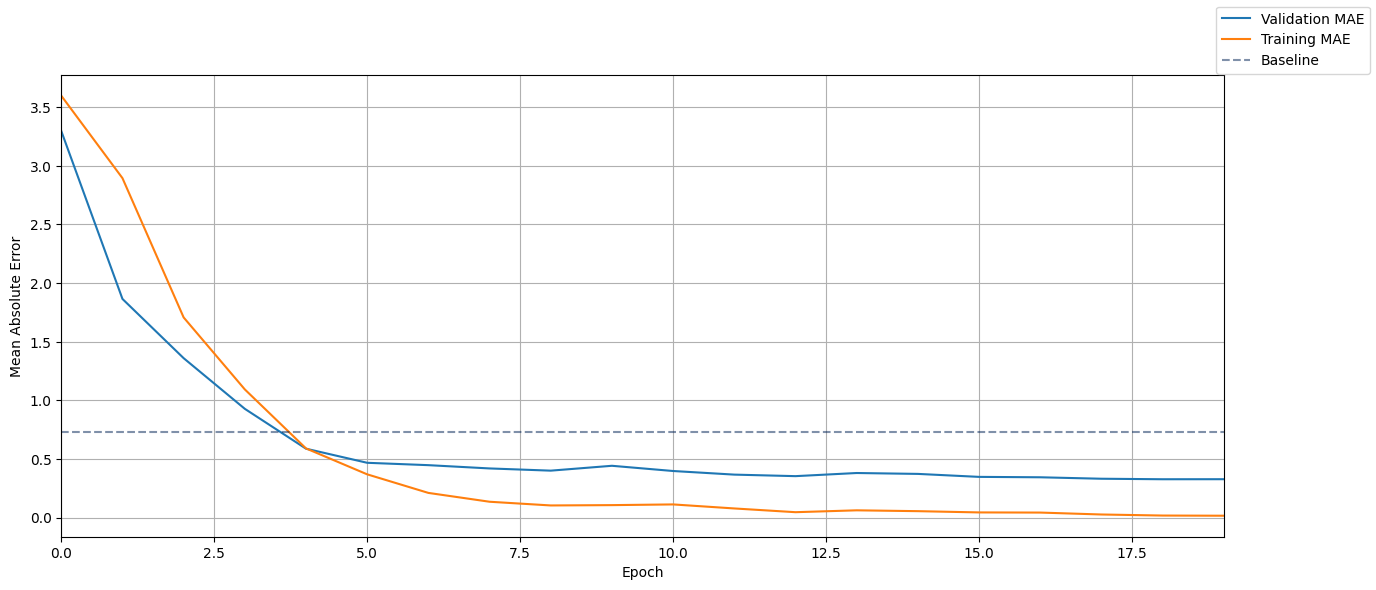

In [20]:
import matplotlib.pyplot as plt

# Step 5: Visualize training and validation MAE
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(history.epoch, history.history['val_mean_absolute_error'], label='Validation MAE')
ax.plot(history.epoch, history.history['mean_absolute_error'], label='Training MAE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Absolute Error')
ax.set_xlim(left=0, right=history.epoch[-1])
baseline_mae = 0.73  # Baseline MAE (replace with the actual baseline you calculated)
ax.axhline(baseline_mae, ls='--', label='Baseline', color='#002255', alpha=0.5)
ax.grid()
fig.legend()
plt.show()


In [28]:
# Step 6: Save the model
model.save('movie_rating_model.keras')

# # Step 7: Load the model
# from keras.models import load_model
# loaded_model = load_model('movie_rating_model.h5')


In [26]:
model.save_weights('movie_rating_embeddings.weights.h5')


In [51]:
import numpy as np
from keras_preprocessing.sequence import pad_sequences

# Function to encode the keywords and prepare input
def prepare_input(movie_id, keywords, max_keywords_length, keyword_encoder):
    # Encode movie_id
    encoded_movie_id = np.array([movie_id])  # Convert to numpy array

    # Encode keywords with handling for unseen labels
    encoded_keywords = []
    for kw in keywords:
        try:
            encoded_keywords.append(keyword_encoder.transform([kw])[0])  # Transform each keyword
        except ValueError:
            encoded_keywords.append(-1)  # Assign -1 or a default value for unseen labels
    
    # Pad the keywords to the max length
    padded_keywords = pad_sequences([encoded_keywords], maxlen=max_keywords_length, padding='post')

    return encoded_movie_id, padded_keywords

# Example Input
movie_id = 313369  # Replace with your desired movie ID
keywords = ["dancing", "jazz", "dance", "traffic jam", "ambition", "musical", "casting", "coffee shop", "jazz club", "hollywood", "los angeles, california", "pianist", "pier", "audition", "planetarium", "aspiring actor", "movie set", "sunset", "one woman show", "pool party", "griffith observatory",
 "romantic", "cheerful"]


max_keywords_length = 20  # Replace with your max length used during training

encoded_movie_id, padded_keywords = prepare_input(movie_id, keywords, max_keywords_length, le)


In [52]:
# Make the prediction
predicted_rating = model.predict([encoded_movie_id, padded_keywords])

# Print the predicted rating
print(f"Predicted rating for movie ID {movie_id} with keywords {keywords}:\n {np.round(predicted_rating[0][0]*2)/2:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted rating for movie ID 313369 with keywords ['dancing', 'jazz', 'dance', 'traffic jam', 'ambition', 'musical', 'casting', 'coffee shop', 'jazz club', 'hollywood', 'los angeles, california', 'pianist', 'pier', 'audition', 'planetarium', 'aspiring actor', 'movie set', 'sunset', 'one woman show', 'pool party', 'griffith observatory', 'romantic', 'cheerful']:
 4.50
